In [1]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import keras.backend as K
from scipy import ndimage
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from datetime import datetime

2025-02-18 09:51:05.402898: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 09:51:05.444891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 09:51:06.048680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Constants and Paths (unchanged)
BASE_PATH = "/home/user/adithyaes/dataset/isles2022_png"
AUG_PATH = "/home/user/adithyaes/dataset/isles2022_png_aug"
INPUT_PATH = os.path.join(BASE_PATH, "input")
MASK_PATH = os.path.join(BASE_PATH, "mask")
AUG_INPUT_PATH = os.path.join(AUG_PATH, "input")
AUG_MASK_PATH = os.path.join(AUG_PATH, "mask")
OUTPUT_DIRECTORY = "./output/ISLESfolder"
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

In [3]:
IMG_SIZE = 112
BATCH_SIZE = 4
LEARNINGRATE = 0.001
EPOCHS = 150
EARLYSTOPPING = 60
scaler = MinMaxScaler(feature_range=(-1, 1))

In [4]:
def dice_coeff(y_true, y_pred):
	y_true_f = K.flatten(y_true)
	y_pred_f = K.flatten(y_pred)
	intersection = K.sum(y_true_f * y_pred_f)
	return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def iou(y_true, y_pred):
	intersection = K.sum(y_true * y_pred)
	union = K.sum(y_true + y_pred)
	return (intersection + 0.1) / (union - intersection + 0.1)

def dice_loss(y_true, y_pred):
	return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1 - dice_coeff(y_true, y_pred))

def single_dice_loss(y_true, y_pred):
    return 1.0 - dice_score(y_true, y_pred)

def binary_crossentropy_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(focal_loss)
    return focal_loss

In [5]:
def load_and_preprocess(file_path, is_mask=False):
	img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
	img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
	if not is_mask:
		img = scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)
	else:
		img = img / 255.0
	return img

In [6]:
# HIMRA Augmentation Functions
def grow_small_lesion(image, mask, target_size=45):
	"""Grow small lesions to approach 50 pixels while staying within brain boundaries"""
	brain_mask = (image != -1)
	current_size = np.sum(mask > 0)
	if current_size == 0 or current_size >= 25: # upto 25 pixel lesions only
		return image, mask
		
	iterations = 0
	grown_mask = mask.copy()
	grown_image = image.copy()
	
	while np.sum(grown_mask > 0) < target_size and iterations < 10:
		kernel = np.ones((3,3), np.uint8)
		dilated = ndimage.binary_dilation(grown_mask, kernel)
		# Only grow within brain boundaries
		dilated = dilated & brain_mask
		new_size = np.sum(dilated > 0)
		
		if new_size > 12:
			break
			
		# Update both mask and image
		grown_mask = dilated
		# Adjust image intensity in grown regions
		new_lesion_area = dilated & ~(mask > 0)
		grown_image[new_lesion_area] = np.mean(image[mask > 0])
		
		iterations += 1
	
	return grown_image, grown_mask.astype(mask.dtype)

def biomechanical_deformation(image, mask, lesion_class):
	"""
	Applies biomechanically realistic deformation using stiffness-weighted elastic deformation.
	"""
	if lesion_class == 1:  # Less than 50 pixels
		image, mask = grow_small_lesion(image, mask)
	
	lesion_pixels = np.where(mask > 0) # Store all (x, y) coordinates of lesion pixels
	if len(lesion_pixels[0]) == 0:
		return image, mask
	
	scales = {1: 15, 2: 12, 3: 9, 4: 7, 5: 5}
	deform_scale = scales[lesion_class]
	
	centroid = np.array([np.mean(lesion_pixels[0]), np.mean(lesion_pixels[1])])
	y_dist = np.abs(np.indices(image.shape)[0] - centroid[0])
	x_dist = np.abs(np.indices(image.shape)[1] - centroid[1])
	
	tissue_stiffness = np.exp(-0.02 * (x_dist**2 + 0.5*y_dist**2))
	dx = deform_scale * tissue_stiffness * gaussian_filter(np.random.randn(*image.shape), sigma=3)
	dy = deform_scale * tissue_stiffness * gaussian_filter(np.random.randn(*image.shape), sigma=3)
	
	y, x = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
	deformed_coords = np.stack([y + dy * 5, x + dx * 5])
	
	return map_coordinates(image, deformed_coords, order=1, mode='reflect'), map_coordinates(mask, deformed_coords, order=0, mode='constant')

def simulate_hemodynamics(image, mask, lesion_class):
	"""
	Simulates hemodynamic effects using synthetic ADC map variations.
	"""
	contrasts = {
		1: (0.5, 1.7),  # Increased contrast for small lesions
		2: (0.4, 1.6), 
		3: (0.5, 1.5),
		4: (0.6, 1.4),
		5: (0.7, 1.3)
	}
	min_contrast, max_contrast = contrasts[lesion_class]
	
	# Create brain mask
	brain_mask = (image != -1)
	
	vessel_mask = gaussian_filter(np.random.binomial(1, 0.03, size=image.shape), sigma=1)
	perfusion_map = gaussian_filter(np.random.normal(1.0, 0.3, size=image.shape), sigma=2)
	
	perfusion_map[vessel_mask > 0.5] *= np.random.uniform(max_contrast - 0.2, max_contrast)
	
	if np.sum(mask > 0) > 0:
		# Enhance lesion visibility
		lesion_area = mask > 0
		perfusion_map[lesion_area] = np.random.uniform(1.3, 1.5)  # Make lesions brighter
		
		distance = ndimage.distance_transform_edt(1 - mask)
		penumbra = (distance < 7) & (mask == 0) & brain_mask
		perfusion_map[penumbra] *= np.random.uniform(min_contrast + 0.3, min_contrast + 0.5)
	
	# Apply perfusion only within brain
	enhanced_image = image.copy()
	enhanced_image[brain_mask] = image[brain_mask] * perfusion_map[brain_mask]
	enhanced_image[~brain_mask] = -1.0
	
	return np.clip(enhanced_image, -1, 1), mask

def attention_occlusion(image, mask):
	"""
	Applies attention-guided occlusion to simulate adversarial conditions.
	"""
	# Create brain mask (all non-zero pixels)
	brain_mask = (image != -1)
	
	noise_scale = np.random.uniform(3, 6)
	attention_field = gaussian_filter(np.random.randn(*image.shape), sigma=noise_scale)
	attention_field = np.abs(attention_field)
	attention_field = (attention_field - attention_field.min()) / (attention_field.max() - attention_field.min())
	attention_field = attention_field * 0.3 + 0.7  # Reduce effect strength
	
	# Only apply attention field within brain region
	attention_field[~brain_mask] = 1.0
	
	# Apply modulation
	modulated_image = image * attention_field
	
	# Preserve background
	modulated_image[~brain_mask] = image[~brain_mask]
	
	return modulated_image, mask

In [7]:
class HIMRADataGenerator(tf.keras.utils.Sequence):
	def __init__(self, list_IDs, aug_ids=None, batch_size=BATCH_SIZE, shuffle=True):
		self.batch_size = batch_size
		self.list_IDs = list_IDs
		self.aug_ids = aug_ids if aug_ids is not None else []
		self.all_ids = list_IDs + self.aug_ids
		self.shuffle = shuffle
		self.on_epoch_end()

	def __len__(self):
		return int(np.floor(len(self.all_ids) / self.batch_size))

	def __getitem__(self, index):
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
		batch_ids = [self.all_ids[k] for k in indexes]
		return self.__data_generation(batch_ids)

	def on_epoch_end(self):
		self.indexes = np.arange(len(self.all_ids))
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, batch_ids):
		X, y = [], []
		for case_id in batch_ids:
			is_aug = case_id in self.aug_ids
			input_dir = AUG_INPUT_PATH if is_aug else INPUT_PATH
			mask_dir = AUG_MASK_PATH if is_aug else MASK_PATH

			input_files = sorted([f for f in os.listdir(input_dir)
								if f.startswith(f'slice_{case_id}') and f.endswith('.png')])

			for f in input_files:
				img_path = os.path.join(input_dir, f)
				mask_path = os.path.join(mask_dir, f)

				img = load_and_preprocess(img_path)
				mask = load_and_preprocess(mask_path, is_mask=True)

				# Determine lesion class for class-aware augmentation
				lesion_size = np.sum(mask)
				lesion_class = 1 if lesion_size < 50 else 2 if lesion_size < 100 else 3 if lesion_size < 150 else 4 if lesion_size < 200 else 5

				# HIMRA Augmentation
				if is_aug:
					img, mask = biomechanical_deformation(img, mask, lesion_class)
					img, mask = simulate_hemodynamics(img, mask, lesion_class)
					# img, mask = attention_occlusion(img, mask)

				X.append(img)
				y.append(mask)

		return np.expand_dims(np.array(X), -1), np.array(y)

In [8]:
# def conv_block(inp, filters):
# 	x = Conv2D(filters, 3, padding='same', use_bias=False)(inp)
# 	x = BatchNormalization()(x)
# 	return Activation('relu')(x)

# def attention_gate(x, g, filters):
# 	g1 = Conv2D(filters, 1)(g)
# 	x1 = Conv2D(filters, 1)(x)
# 	out = Activation('relu')(add([g1, x1]))
# 	out = Conv2D(1, 1, activation='sigmoid')(out)
# 	return multiply([x, out])


def dice_score(y_true, y_pred):
	intersection = tf.reduce_sum(y_true * y_pred)
	union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
	dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
	return dice

def conv_block(inp, filters):
	x = Conv2D(filters, (3,3), padding='same', activation='relu')(inp)
	x = Conv2D(filters, (3,3), padding='same')(x)
	x = BatchNormalization(axis=3)(x)
	x = Activation('relu')(x)
	return x

def encoder_block(inp, filters):
	x = conv_block(inp, filters)
	p = MaxPooling2D(pool_size=(2,2))(x)
	return x, p

def attention_block(l_layer, h_layer):
	phi = Conv2D(h_layer.shape[-1], (1,1), padding='same')(l_layer)
	theta = Conv2D(h_layer.shape[-1], (1,1), strides=(2,2), padding='same')(h_layer)
	x = tf.keras.layers.add([phi, theta])
	x = Activation('relu')(x)
	x = Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)
	x = UpSampling2D(size=(2,2))(x)
	x = tf.keras.layers.multiply([h_layer, x])
	x = BatchNormalization(axis=3)(x)
	return x

def decoder_block(inp, filters, concat_layer):
	x = Conv2DTranspose(filters, (2,2), strides=(2,2), padding='same')(inp)
	x = concatenate([x, concat_layer])
	x = conv_block(x, filters)
	return x

In [9]:
# def create_model():
# 	inputs = Input((IMG_SIZE, IMG_SIZE, 1))

# 	# Encoder with reduced filters
# 	x = conv_block(inputs, 32)
# 	skip1 = x
# 	x = MaxPooling2D()(x)

# 	x = conv_block(x, 64)
# 	skip2 = x
# 	x = MaxPooling2D()(x)

# 	x = conv_block(x, 128)
# 	skip3 = x
# 	x = MaxPooling2D()(x)

# 	x = conv_block(x, 256)
# 	skip4 = x
# 	x = MaxPooling2D()(x)

# 	# Bridge
# 	x = conv_block(x, 512)

# 	# Decoder with attention
# 	x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)
# 	x = attention_gate(skip4, x, 256)
# 	x = concatenate([x, skip4])
# 	x = conv_block(x, 256)

# 	x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
# 	x = attention_gate(skip3, x, 128)
# 	x = concatenate([x, skip3])
# 	x = conv_block(x, 128)

# 	x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
# 	x = attention_gate(skip2, x, 64)
# 	x = concatenate([x, skip2])
# 	x = conv_block(x, 64)

# 	x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
# 	x = attention_gate(skip1, x, 32)
# 	x = concatenate([x, skip1])
# 	x = conv_block(x, 32)

# 	outputs = Conv2D(1, 1, activation='sigmoid')(x)

# 	model = Model(inputs, outputs)

# 	model.compile(
# 		optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNINGRATE),
# 		loss=dice_loss,
# 		metrics=['accuracy', dice_coeff, iou]
# 	)

# 	return model


def create_model():
    inputs = Input((112,112,1))

    d1, p1 = encoder_block(inputs, 32)
    d2, p2 = encoder_block(p1, 64)
    d3, p3 = encoder_block(p2, 128)
    d4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 1024)

    e2 = decoder_block(b1, 256, d4)
    e3 = decoder_block(e2, 128, d3)
    e4 = decoder_block(e3, 64, d2)
    e5 = decoder_block(e4, 32, d1)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(e5)

    model = Model(inputs=[inputs], outputs=[outputs], name='AttentionUnet')

    model.compile(
        loss=single_dice_loss,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy', dice_coeff, dice_score, iou]
    )

    return model

In [10]:
def get_case_ids(path):
	files = sorted([f for f in os.listdir(path) if f.endswith('.png')])
	return sorted(list({f.split('_')[1] for f in files}))

In [11]:
def plot_training_metrics(history):
    """
    Visualize training and validation metrics over epochs
    """
    metrics = ['loss', 'dice_coeff', 'iou', 'accuracy']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Over Epochs', fontsize=16)

    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        ax.plot(history.history[metric], label=f'Training {metric}')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        ax.set_title(f'{metric.replace("_", " ").title()} vs Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.legend(loc='best')
        ax.grid(True)

    plt.tight_layout()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'training_metrics_{timestamp}.png'),
                bbox_inches='tight', dpi=300)
    plt.close()


def visualize_augmented_samples(train_gen, num_samples=3):
    plt.figure(figsize=(15, 10))

    for batch_x, batch_y in train_gen:
        aug_images = batch_x
        aug_masks = batch_y
        break

    for idx in range(min(num_samples, len(aug_images))):
        # Augmented Image
        plt.subplot(2, num_samples, idx + 1)
        plt.imshow(aug_images[idx, :, :, 0], cmap='gray')
        plt.title(f'Augmented Image {idx+1}')
        plt.axis('off')

        # Corresponding Mask
        plt.subplot(2, num_samples, num_samples + idx + 1)
        plt.imshow(aug_masks[idx], cmap='gray')
        plt.title(f'Augmented Mask {idx+1}')
        plt.axis('off')

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'augmentation_samples_{timestamp}.png'),
                bbox_inches='tight', dpi=300)
    plt.close()


def visualize_segmentation_results(model, test_gen, num_samples=3):
    for batch_x, batch_y in test_gen:
        test_images = batch_x
        true_masks = batch_y
        break

    predictions = model.predict(test_images)
    predictions = (predictions > 0.5).astype(np.float32)  # Change to float32 instead of uint8

    plt.figure(figsize=(15, 20))

    for idx in range(min(num_samples, len(test_images))):
        plt.subplot(num_samples, 2, 2*idx + 1)
        plt.imshow(test_images[idx, :, :, 0], cmap='gray')
        plt.title(f'Input DWI Image {idx+1}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*idx + 2)
        plt.imshow(predictions[idx, :, :, 0], cmap='gray')
        dice_score = numpy_dice_coeff(true_masks[idx], predictions[idx, :, :, 0])
        iou_score = numpy_iou(true_masks[idx], predictions[idx, :, :, 0])
        plt.title(f'Predicted Segmentation {idx+1}\n' +
                 f'Dice: {dice_score:.4f}, IoU: {iou_score:.4f}')
        plt.axis('off')

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'segmentation_results_{timestamp}.png'),
                bbox_inches='tight', dpi=300)
    plt.close()

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

case_ids = get_case_ids(INPUT_PATH)
aug_case_ids = get_case_ids(AUG_INPUT_PATH) if os.path.exists(AUG_INPUT_PATH) else []

train_ids, test_ids = train_test_split(case_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}, Aug: {len(aug_case_ids)}")

train_gen = HIMRADataGenerator(train_ids, aug_ids=aug_case_ids)
val_gen = HIMRADataGenerator(val_ids, shuffle=False)
test_gen = HIMRADataGenerator(test_ids, shuffle=False)

model = create_model()

print("Model Summary: ", model.summary())

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_dice_coeff', mode='max',
                   save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=EARLYSTOPPING, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    workers=4,
    use_multiprocessing=True
)

results = model.evaluate(test_gen)

print("\nGenerating Training Metrics Visualization...")
plot_training_metrics(history)


Train: 160, Val: 40, Test: 50, Aug: 63


2025-02-18 09:51:07.270095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14400 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:19:00.0, compute capability: 8.6


Model: "AttentionUnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  9248        ['conv2d[0][0]']                 
                                )                                                     

2025-02-18 09:51:08.031431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-02-18 09:51:12.233342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-02-18 09:51:16.471316: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f45ee268c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-18 09:51:16.471345: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-02-18 09:51:16.475274: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-18 09:51:16.619929: I 

 1/55 [..............................] - ETA: 25:43 - loss: 0.9967 - accuracy: 0.6080 - dice_coeff: 0.0033 - dice_score: 0.0033 - iou: 0.0017

2025-02-18 09:51:43.772206: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-18 09:51:43.953321: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-18 09:51:43.953363: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 5/55 [=>............................] - ETA: 14:29 - loss: 0.9794 - accuracy: 0.7333 - dice_coeff: 0.0205 - dice_score: 0.0205 - iou: 0.0104

2025-02-18 09:52:55.557408: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-18 09:52:55.843506: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-18 09:52:55.843555: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 9/55 [===>..........................] - ETA: 15:41 - loss: 0.9766 - accuracy: 0.7568 - dice_coeff: 0.0226 - dice_score: 0.0226 - iou: 0.0115

2025-02-18 09:54:29.227258: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-18 09:54:29.469197: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-18 09:54:29.469245: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


10/55 [====>.........................] - ETA: 15:56 - loss: 0.9751 - accuracy: 0.7631 - dice_coeff: 0.0240 - dice_score: 0.0240 - iou: 0.0122

2025-02-18 09:54:54.263168: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.87GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


19/55 [=========>....................] - ETA: 12:42 - loss: 0.9727 - accuracy: 0.7801 - dice_coeff: 0.0261 - dice_score: 0.0261 - iou: 0.0133

2025-02-18 09:58:08.103671: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


55/55 [==============================] - ETA: 0s - loss: 0.9635 - accuracy: 0.8580 - dice_coeff: 0.0356 - dice_score: 0.0356 - iou: 0.0182 

2025-02-18 10:03:40.698785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_dice_coeff improved from -inf to 0.01626, saving model to best_model.h5
55/55 [==============================] - 775s 14s/step - loss: 0.9635 - accuracy: 0.8580 - dice_coeff: 0.0356 - dice_score: 0.0356 - iou: 0.0182 - val_loss: 0.9845 - val_accuracy: 0.9938 - val_dice_coeff: 0.0163 - val_dice_score: 0.0163 - val_iou: 0.0082 - lr: 0.0010
Epoch 2/150
55/55 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.9565 - dice_coeff: 0.0568 - dice_score: 0.0568 - iou: 0.0296
Epoch 2: val_dice_coeff improved from 0.01626 to 0.04108, saving model to best_model.h5
55/55 [==============================] - 308s 6s/step - loss: 0.9414 - accuracy: 0.9565 - dice_coeff: 0.0568 - dice_score: 0.0568 - iou: 0.0296 - val_loss: 0.9610 - val_accuracy: 0.9337 - val_dice_coeff: 0.0411 - val_dice_score: 0.0411 - val_iou: 0.0212 - lr: 0.0010
Epoch 3/150
55/55 [==============================] - ETA: 0s - loss: 0.8280 - accuracy: 0.9872 - dice_coeff: 0.1697 - dice_score: 0.1697 - i

2025-02-18 11:59:15.718576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 12s 999ms/step - loss: 0.3073 - accuracy: 0.9986 - dice_coeff: 0.7026 - dice_score: 0.7025 - iou: 0.5603

Generating Training Metrics Visualization...


In [13]:
print("\nTest Results:")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Dice Score: {results[2]:.4f}")
print(f"IoU: {results[3]:.4f}")


Test Results:
Loss: 0.3073
Accuracy: 0.9986
Dice Score: 0.7026
IoU: 0.7025


In [14]:
print("Generating Augmentation Samples Visualization...")
visualize_augmented_samples(train_gen)

Generating Augmentation Samples Visualization...


In [15]:
def numpy_dice_coeff(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1)

def numpy_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    return (intersection + 0.1) / (union - intersection + 0.1)

def visualize_segmentation_results(model, test_gen, num_samples=3):
    for batch_x, batch_y in test_gen:
        test_images = batch_x
        true_masks = batch_y
        break

    predictions = model.predict(test_images)
    predictions = (predictions > 0.5).astype(np.float32)  # Change to float32 instead of uint8

    plt.figure(figsize=(15, 20))

    for idx in range(min(num_samples, len(test_images))):
        plt.subplot(num_samples, 2, 2*idx + 1)
        plt.imshow(test_images[idx, :, :, 0], cmap='gray')
        plt.title(f'Input DWI Image {idx+1}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*idx + 2)
        plt.imshow(predictions[idx, :, :, 0], cmap='gray')
        dice_score = numpy_dice_coeff(true_masks[idx], predictions[idx, :, :, 0])
        iou_score = numpy_iou(true_masks[idx], predictions[idx, :, :, 0])
        plt.title(f'Predicted Segmentation {idx+1}\n' +
                 f'Dice: {dice_score:.4f}, IoU: {iou_score:.4f}')
        plt.axis('off')

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'segmentation_results_{timestamp}.png'),
                bbox_inches='tight', dpi=300)
    plt.close()

In [16]:
print("\nGenerating Segmentation Results Visualization...")
visualize_segmentation_results(model, test_gen)


Generating Segmentation Results Visualization...
10/10 [==============================] - 2s 57ms/step


In [17]:
print(f"\nAll visualizations have been saved to: {OUTPUT_DIRECTORY}")


All visualizations have been saved to: ./output/ISLESfolder


1/1 [==============================] - 0s 380ms/step
Dice Score: 0.9024
IoU Score: 0.8212


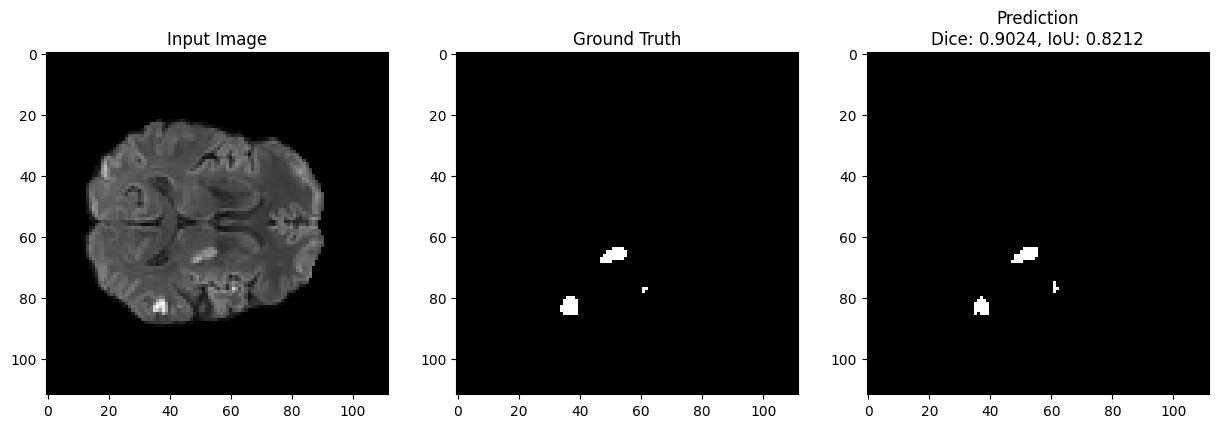

In [18]:
# Load specific image
test_image_path = os.path.join(INPUT_PATH, "slice_sub-strokecase0009_0038.png")
test_mask_path = os.path.join(MASK_PATH, "slice_sub-strokecase0009_0038.png")

# Load and preprocess
test_image = load_and_preprocess(test_image_path)
test_image = np.expand_dims(test_image, axis=[0,-1])
test_mask = load_and_preprocess(test_mask_path, is_mask=True)

# Predict
prediction = model.predict(test_image)
prediction = (prediction > 0.5).astype(np.float32)[0,:,:,0]

# Calculate metrics
dice = numpy_dice_coeff(test_mask, prediction)
iou = numpy_iou(test_mask, prediction)

print(f"Dice Score: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")

# Visualize
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title(f'Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}')
plt.show()

1/1 [==============================] - 0s 20ms/step
Dice Score: 0.9541
IoU Score: 0.9120


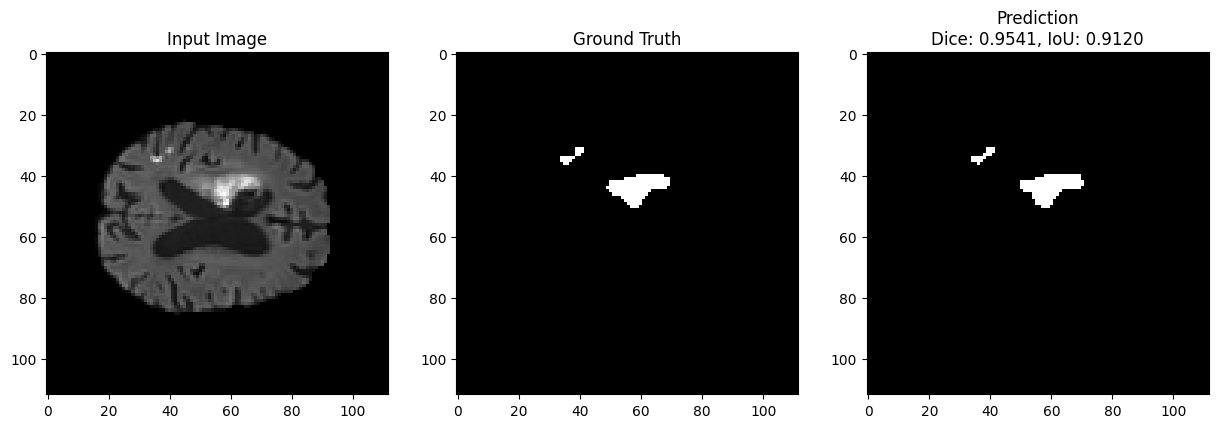

In [19]:
# Load specific image
test_image_path = os.path.join(INPUT_PATH, "slice_sub-strokecase0013_0045.png")
test_mask_path = os.path.join(MASK_PATH, "slice_sub-strokecase0013_0045.png")

# Load and preprocess
test_image = load_and_preprocess(test_image_path)
test_image = np.expand_dims(test_image, axis=[0,-1])
test_mask = load_and_preprocess(test_mask_path, is_mask=True)

# Predict
prediction = model.predict(test_image)
prediction = (prediction > 0.5).astype(np.float32)[0,:,:,0]

# Calculate metrics
dice = numpy_dice_coeff(test_mask, prediction)
iou = numpy_iou(test_mask, prediction)

print(f"Dice Score: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")

# Visualize
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title(f'Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}')
plt.show()

1/1 [==============================] - 0s 19ms/step
Dice Score: 0.9601
IoU Score: 0.9231


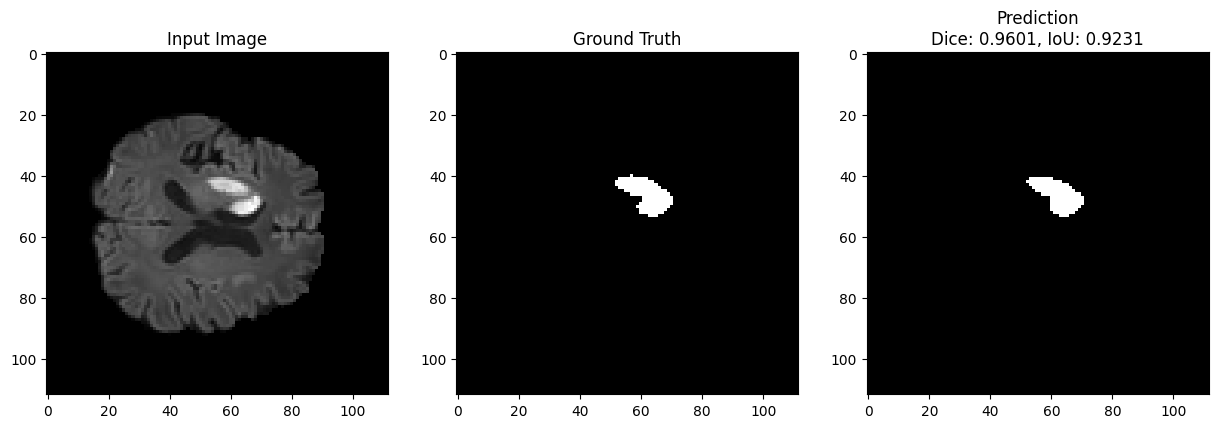

In [20]:
# Load specific image
test_image_path = os.path.join(INPUT_PATH, "slice_sub-strokecase0015_0041.png")
test_mask_path = os.path.join(MASK_PATH, "slice_sub-strokecase0015_0041.png")

# Load and preprocess
test_image = load_and_preprocess(test_image_path)
test_image = np.expand_dims(test_image, axis=[0,-1])
test_mask = load_and_preprocess(test_mask_path, is_mask=True)

# Predict
prediction = model.predict(test_image)
prediction = (prediction > 0.5).astype(np.float32)[0,:,:,0]

# Calculate metrics
dice = numpy_dice_coeff(test_mask, prediction)
iou = numpy_iou(test_mask, prediction)

print(f"Dice Score: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")

# Visualize
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title(f'Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}')
plt.show()

1/1 [==============================] - 0s 19ms/step
Dice Score: 0.8653
IoU Score: 0.7623


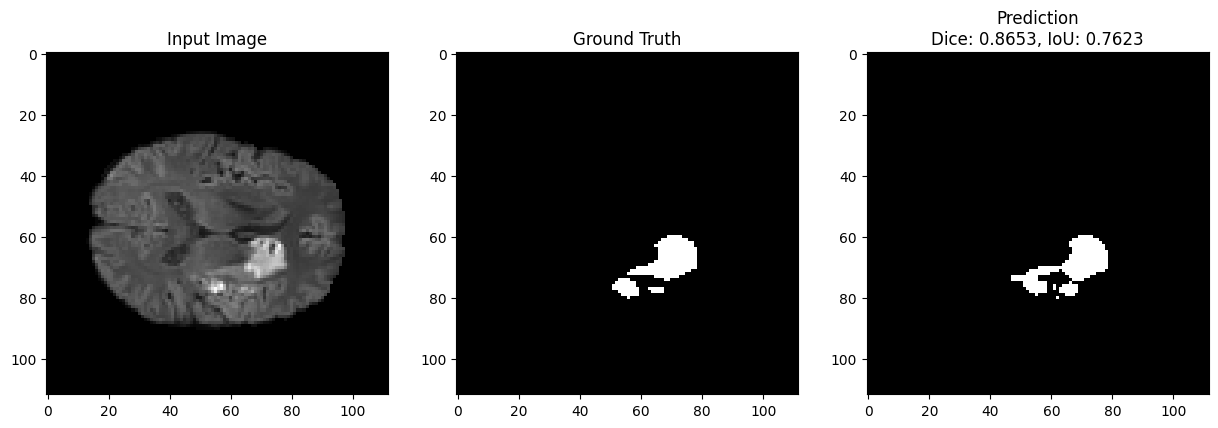

In [21]:
# Load specific image
test_image_path = os.path.join(INPUT_PATH, "slice_sub-strokecase0024_0039.png")
test_mask_path = os.path.join(MASK_PATH, "slice_sub-strokecase0024_0039.png")

# Load and preprocess
test_image = load_and_preprocess(test_image_path)
test_image = np.expand_dims(test_image, axis=[0,-1])
test_mask = load_and_preprocess(test_mask_path, is_mask=True)

# Predict
prediction = model.predict(test_image)
prediction = (prediction > 0.5).astype(np.float32)[0,:,:,0]

# Calculate metrics
dice = numpy_dice_coeff(test_mask, prediction)
iou = numpy_iou(test_mask, prediction)

print(f"Dice Score: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")

# Visualize
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title(f'Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}')
plt.show()

1/1 [==============================] - 0s 20ms/step
Dice Score: 0.8506
IoU Score: 0.7399


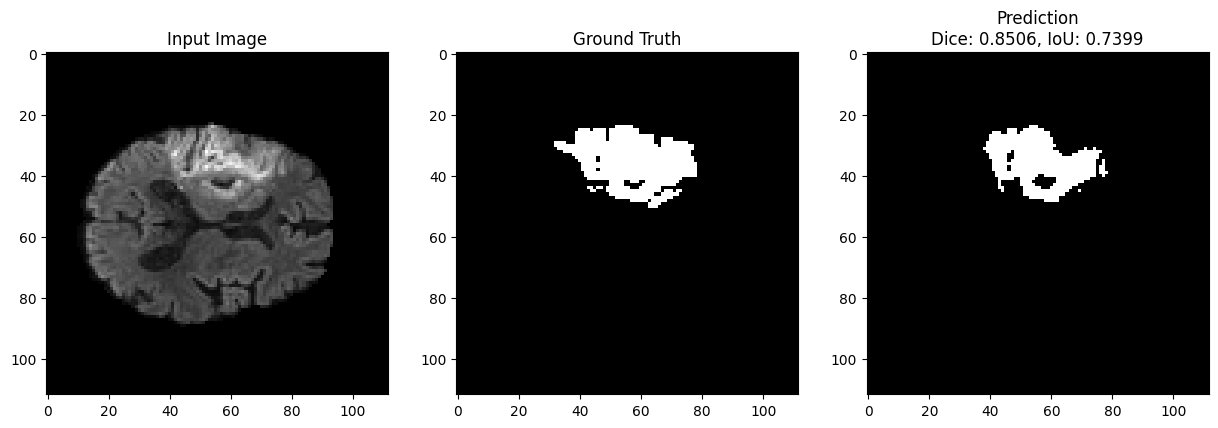

In [22]:
# Load specific image
test_image_path = os.path.join(INPUT_PATH, "slice_sub-strokecase0031_0036.png")
test_mask_path = os.path.join(MASK_PATH, "slice_sub-strokecase0031_0036.png")

# Load and preprocess
test_image = load_and_preprocess(test_image_path)
test_image = np.expand_dims(test_image, axis=[0,-1])
test_mask = load_and_preprocess(test_mask_path, is_mask=True)

# Predict
prediction = model.predict(test_image)
prediction = (prediction > 0.5).astype(np.float32)[0,:,:,0]

# Calculate metrics
dice = numpy_dice_coeff(test_mask, prediction)
iou = numpy_iou(test_mask, prediction)

print(f"Dice Score: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")

# Visualize
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title(f'Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}')
plt.show()

1/1 [==============================] - 0s 20ms/step
Dice Score: 1.0000
IoU Score: 1.0000


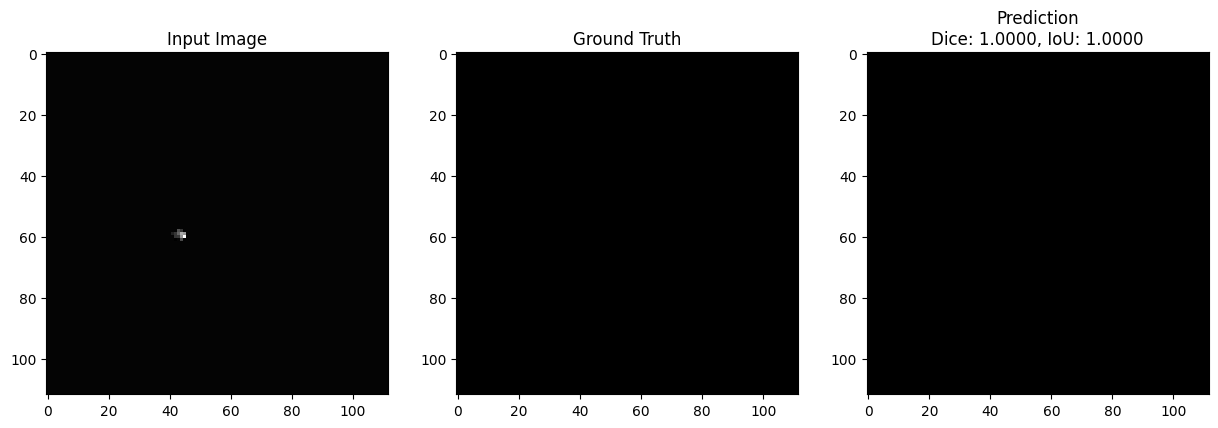

In [23]:
# Load specific image
test_image_path = os.path.join(INPUT_PATH, "slice_sub-strokecase0240_0068.png")
test_mask_path = os.path.join(MASK_PATH, "slice_sub-strokecase0240_0068.png")

# Load and preprocess
test_image = load_and_preprocess(test_image_path)
test_image = np.expand_dims(test_image, axis=[0,-1])
test_mask = load_and_preprocess(test_mask_path, is_mask=True)

# Predict
prediction = model.predict(test_image)
prediction = (prediction > 0.5).astype(np.float32)[0,:,:,0]

# Calculate metrics
dice = numpy_dice_coeff(test_mask, prediction)
iou = numpy_iou(test_mask, prediction)

print(f"Dice Score: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")

# Visualize
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title(f'Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}')
plt.show()

1/1 [==============================] - 0s 23ms/step
Dice Score: 0.3333
IoU Score: 0.1549


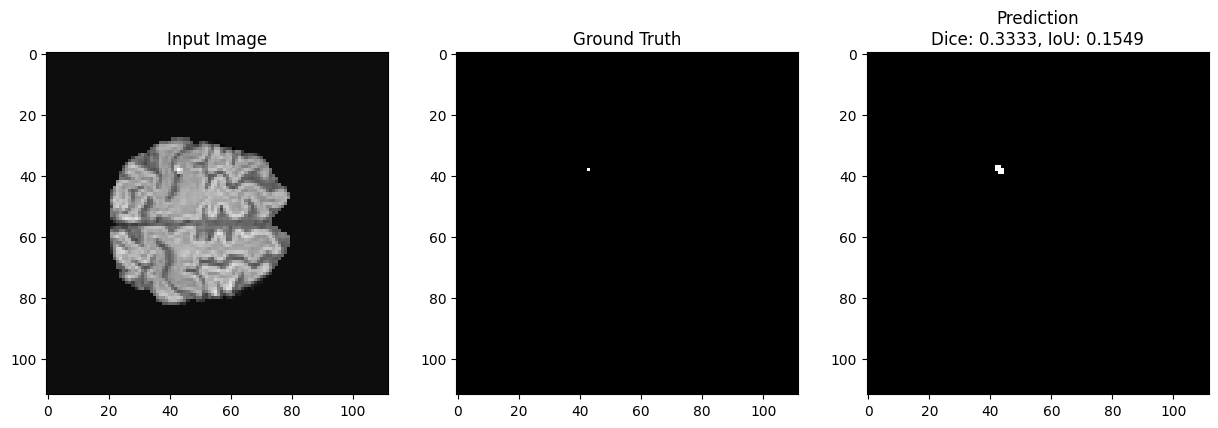

In [24]:
# Load specific image
test_image_path = os.path.join(INPUT_PATH, "slice_sub-strokecase0036_0056.png")
test_mask_path = os.path.join(MASK_PATH, "slice_sub-strokecase0036_0056.png")

# Load and preprocess
test_image = load_and_preprocess(test_image_path)
test_image = np.expand_dims(test_image, axis=[0,-1])
test_mask = load_and_preprocess(test_mask_path, is_mask=True)

# Predict
prediction = model.predict(test_image)
prediction = (prediction > 0.5).astype(np.float32)[0,:,:,0]

# Calculate metrics
dice = numpy_dice_coeff(test_mask, prediction)
iou = numpy_iou(test_mask, prediction)

print(f"Dice Score: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")

# Visualize
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(test_image[0,:,:,0], cmap='gray')
plt.title('Input Image')
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title(f'Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}')
plt.show()

In [25]:
def grow_small_lesion(image, mask, target_size=45):
    """Grow small lesions to approach 50 pixels while staying within brain boundaries"""
    brain_mask = (image != -1)
    current_size = np.sum(mask > 0)
    if current_size == 0 or current_size >= 50:
        return image, mask
        
    iterations = 0
    grown_mask = mask.copy()
    grown_image = image.copy()
    
    while np.sum(grown_mask > 0) < target_size and iterations < 10:
        kernel = np.ones((3,3), np.uint8)
        dilated = ndimage.binary_dilation(grown_mask, kernel)
        # Only grow within brain boundaries
        dilated = dilated & brain_mask
        new_size = np.sum(dilated > 0)
        
        if new_size > 12: # lesions with minimmal pixels
            break
            
        # Update both mask and image
        grown_mask = dilated
        # Adjust image intensity in grown regions
        new_lesion_area = dilated & ~(mask > 0)
        grown_image[new_lesion_area] = np.mean(image[mask > 0])
        
        iterations += 1
    
    return grown_image, grown_mask.astype(mask.dtype)

def biomechanical_deformation(image, mask, lesion_class):
    """Process small lesions differently"""
    if lesion_class == 1:  # Less than 50 pixels
        image, mask = grow_small_lesion(image, mask)
    
    lesion_pixels = np.where(mask > 0)
    if len(lesion_pixels[0]) == 0:
        return image, mask
    
    scales = {1: 15, 2: 12, 3: 9, 4: 7, 5: 5}
    deform_scale = scales[lesion_class]
    
    centroid = np.array([np.mean(lesion_pixels[0]), np.mean(lesion_pixels[1])])
    y_dist = np.abs(np.indices(image.shape)[0] - centroid[0])
    x_dist = np.abs(np.indices(image.shape)[1] - centroid[1])
    
    tissue_stiffness = np.exp(-0.02 * (x_dist**2 + 0.5*y_dist**2))
    dx = deform_scale * tissue_stiffness * gaussian_filter(np.random.randn(*image.shape), sigma=3)
    dy = deform_scale * tissue_stiffness * gaussian_filter(np.random.randn(*image.shape), sigma=3)
    
    y, x = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    deformed_coords = np.stack([y + dy * 5, x + dx * 5])
    
    return map_coordinates(image, deformed_coords, order=1, mode='reflect'), map_coordinates(mask, deformed_coords, order=0, mode='constant')

def simulate_hemodynamics(image, mask, lesion_class):
    contrasts = {
        1: (0.5, 1.7),  # Increased contrast for small lesions
        2: (0.4, 1.6), 
        3: (0.5, 1.5),
        4: (0.6, 1.4),
        5: (0.7, 1.3)
    }
    min_contrast, max_contrast = contrasts[lesion_class]
    
    # Create brain mask
    brain_mask = (image != -1)
    
    vessel_mask = gaussian_filter(np.random.binomial(1, 0.03, size=image.shape), sigma=1)
    perfusion_map = gaussian_filter(np.random.normal(1.0, 0.3, size=image.shape), sigma=2)
    
    perfusion_map[vessel_mask > 0.5] *= np.random.uniform(max_contrast - 0.2, max_contrast)
    
    if np.sum(mask > 0) > 0:
        # Enhance lesion visibility
        lesion_area = mask > 0
        perfusion_map[lesion_area] = np.random.uniform(1.3, 1.5)  # Make lesions brighter
        
        distance = ndimage.distance_transform_edt(1 - mask)
        penumbra = (distance < 7) & (mask == 0) & brain_mask
        perfusion_map[penumbra] *= np.random.uniform(min_contrast + 0.3, min_contrast + 0.5)
    
    # Apply perfusion only within brain
    enhanced_image = image.copy()
    enhanced_image[brain_mask] = image[brain_mask] * perfusion_map[brain_mask]
    enhanced_image[~brain_mask] = -1.0
    
    return np.clip(enhanced_image, -1, 1), mask

def attention_occlusion(image, mask):
    # Create precise brain mask
    brain_mask = (image != -1)
    # brain_mask = ndimage.binary_erosion(brain_mask, structure=np.ones((3,3)))
    
    noise_scale = np.random.uniform(3, 6)
    attention_field = gaussian_filter(np.random.randn(*image.shape), sigma=noise_scale)
    attention_field = np.abs(attention_field)
    attention_field = (attention_field - attention_field.min()) / (attention_field.max() - attention_field.min())
    attention_field = attention_field * 0.3 + 0.7  # Reduce effect strength
    
    # Strictly preserve background
    attention_field[~brain_mask] = 1.0
    modulated_image = image * attention_field
    modulated_image[~brain_mask] = -1.0  # Set to background value
    
    return modulated_image, mask

In [26]:
def visualize_himra_augmentation(image_path, mask_path, output_dir):
    """
    Visualize the original image and the three HIMRA augmentation steps side by side.
    """
    # Load and preprocess original image and mask
    original_image = load_and_preprocess(image_path)
    original_mask = load_and_preprocess(mask_path, is_mask=True)

    # Determine lesion class for class-aware augmentation
    lesion_size = np.sum(original_mask)
    lesion_class = 1 if lesion_size < 50 else 2 if lesion_size < 100 else 3 if lesion_size < 150 else 4 if lesion_size < 200 else 5

    # Apply HIMRA augmentation steps
    biomech_image, biomech_mask = biomechanical_deformation(original_image.copy(), original_mask.copy(), lesion_class)
    hemo_image, hemo_mask = simulate_hemodynamics(biomech_image.copy(), biomech_mask.copy(), lesion_class)
    occluded_image, occluded_mask = attention_occlusion(hemo_image.copy(), hemo_mask.copy())

    # Plot the original image and the three HIMRA steps
    plt.figure(figsize=(20, 10))
    plt.suptitle("HIMRA Augmentation Steps", fontsize=16, y=1.05)

    # Original Image and Mask
    plt.subplot(2, 4, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Biomechanical Deformation
    plt.subplot(2, 4, 2)
    plt.imshow(biomech_image, cmap='gray')
    plt.title("Biomechanical Deformation")
    plt.axis('off')

    # Hemodynamic Simulation
    plt.subplot(2, 4, 3)
    plt.imshow(hemo_image, cmap='gray')
    plt.title("Hemodynamic Simulation")
    plt.axis('off')

    # Attention-Guided Occlusion
    plt.subplot(2, 4, 4)
    plt.imshow(occluded_image, cmap='gray')
    plt.title("Attention Occlusion")
    plt.axis('off')
    
    # Masks row
    plt.subplot(2, 4, 5)
    plt.imshow(original_mask, cmap='gray')
    plt.title("Original Mask")
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(biomech_mask, cmap='gray')
    plt.title("Deformed Mask")
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(hemo_mask, cmap='gray')
    plt.title("Hemodynamic Mask")
    plt.axis('off')
    
    plt.subplot(2, 4, 8)
    plt.imshow(occluded_mask, cmap='gray')
    plt.title("Occluded Mask")
    plt.axis('off')
    
    filename = os.path.basename(image_path).replace('.png', '_himra_steps.png')
    save_path = os.path.join(output_dir, filename)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    return save_path


# Directory to save visualizations
output_dir = os.path.join(OUTPUT_DIRECTORY, 'himra_visualizations')
os.makedirs(output_dir, exist_ok=True)

# Test samples to visualize
test_samples = [
    "slice_sub-strokecase0009_0038.png",
    "slice_sub-strokecase0013_0045.png",
    "slice_sub-strokecase0015_0041.png",
    "slice_sub-strokecase0024_0039.png",
    "slice_sub-strokecase0031_0036.png",
    "slice_sub-strokecase0036_0056.png"
]

# Generate and save visualizations
for sample in test_samples:
    image_path = os.path.join(INPUT_PATH, sample)
    mask_path = os.path.join(MASK_PATH, sample)
    save_path = visualize_himra_augmentation(image_path, mask_path, output_dir)
    print(f"Saved HIMRA visualization for {sample} to {save_path}")

Saved HIMRA visualization for slice_sub-strokecase0009_0038.png to ./output/ISLESfolder/himra_visualizations/slice_sub-strokecase0009_0038_himra_steps.png
Saved HIMRA visualization for slice_sub-strokecase0013_0045.png to ./output/ISLESfolder/himra_visualizations/slice_sub-strokecase0013_0045_himra_steps.png
Saved HIMRA visualization for slice_sub-strokecase0015_0041.png to ./output/ISLESfolder/himra_visualizations/slice_sub-strokecase0015_0041_himra_steps.png
Saved HIMRA visualization for slice_sub-strokecase0024_0039.png to ./output/ISLESfolder/himra_visualizations/slice_sub-strokecase0024_0039_himra_steps.png
Saved HIMRA visualization for slice_sub-strokecase0031_0036.png to ./output/ISLESfolder/himra_visualizations/slice_sub-strokecase0031_0036_himra_steps.png
Saved HIMRA visualization for slice_sub-strokecase0036_0056.png to ./output/ISLESfolder/himra_visualizations/slice_sub-strokecase0036_0056_himra_steps.png
